## Setup & Dependencies

In [ ]:
!pip install tqdm
!pip install -U "ray[tune]"
!pip install --user fastai

In [67]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import torch
import multiprocessing

from fastai.text.all import *

import sys
import os

sys.path.insert(0, '/home/jupyter/src/natalies-little-helper/util')
import helpers as helper

In [3]:
# Number of CPU cores available
cpu = multiprocessing.cpu_count()

# Set up cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of GPUs being used
gpu = torch.cuda.device_count() if torch.cuda.is_available() else 0

# CPU and GPU Resources
proc_resources = {'cpu': cpu, 'gpu': gpu}

repo_path = "/home/jupyter/src/natalies-little-helper/"
data_path = repo_path + "data/"
model_path = repo_path + "models/"

## Data Preprocessing

In [4]:
train = pd.read_csv(data_path + 'Tweets.csv')
train = train[train['negativereason'].notna()].reset_index(drop=True)
train.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [5]:
train = train[['text', 'negativereason']]

In [6]:
train.groupby('negativereason').head()

,text,negativereason
0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",Bad Flight
1,@VirginAmerica and it's a really big bad thing about it,Can't Tell
2,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,Can't Tell
3,@VirginAmerica SFO-PDX schedule is still MIA.,Late Flight
4,@VirginAmerica I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!,Bad Flight
5,@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???,Can't Tell
6,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet,Customer Service Issue
7,@VirginAmerica status match program. I applied and it's been three weeks. Called and emailed with no response.,Customer Service Issue
8,@VirginAmerica What happened 2 ur vegan food options?! At least say on ur site so i know I won't be able 2 eat anything for next 6 hrs #fail,Can't Tell
9,@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS,Bad Flight


## ULMFiT Utils

In [7]:
def train_lm(train_data, show_batch=False, metrics=[accuracy, Perplexity()], wd=0.1, epochs=(6,6)):
    # Data Loader
    lang_dls = DataBlock(blocks=(TextBlock.from_df('text', is_lm=True)),
                 get_x=ColReader('text'),
                 splitter=RandomSplitter(valid_pct=0.2))
    lang_dls = lang_dls.dataloaders(train_data, bs=64, seq_len=72, device=torch.device('cuda'))
    lang_dls.show_batch(max_n=4)
    
    # Train LM
    learn = language_model_learner(lang_dls, AWD_LSTM, metrics=metrics, wd=wd).to_fp16()
    
    # First cycle
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs[0], lr.valley, moms=(0.85,0.8,0.75))
    
    # Second cycle
    learn.unfreeze()
    lr = learn.lr_find();
    learn.fit_one_cycle(epochs[1], lr.valley, moms=(0.8,0.75,0.7))
    
    return learn, lang_dls
    
def test_lm(learner, text, n_words, n_sentences):
    print("\n".join(learner.predict(text, n_words, temperature=0.75) for _ in range(n_sentences)))
    
def train_classifier(train_data, lang_dls, encoder_path, label, show_batch=False, metrics=[accuracy, Perplexity()], wd=0.1, epochs=(4, 4, 9)):
    intent_dls = DataBlock(blocks=(TextBlock.from_df('text', vocab=lang_dls.vocab, seq_len=72), CategoryBlock),
                 get_x=ColReader('text'),
                 get_y=ColReader(label),
                 splitter=RandomSplitter(valid_pct=0.2))

    intent_dls = intent_dls.dataloaders(train_data, bs=64, device=torch.device('cuda'))
    intent_dls.show_batch(max_n=4)
    
    learn = text_classifier_learner(intent_dls, AWD_LSTM, metrics=metrics, wd=wd, drop_mult=0.5).to_fp16()
    learn.load_encoder(encoder_path)
    
    # First cycle
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs[0], lr.valley, moms=(0.8,0.75,0.7))
    
    # Second cycle
    learn.freeze_to(-2)
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs[1], lr.valley, moms=(0.8,0.75,0.7))
    # learn.fit_one_cycle(epochs, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.75,0.7))
    
    # Last cycle
    learn.unfreeze()
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs[2], slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.75,0.7))
    # learn.fit_one_cycle(epochs, lr, moms=(0.8,0.75,0.7))
    
    return learn

def test_classifier_acc(learn):
    pred_fwd,lbl_fwd = learn.get_preds()
    return accuracy(pred_fwd, lbl_fwd)
    

# Language Models

## Clean LMs

### Clean data

In [8]:
all_train = pd.read_csv(data_path + 'Tweets.csv')
# all_train = all_train[all_train['airline_sentiment'].notna()].reset_index(drop=True)
# all_train.airline_sentiment.value_counts()
all_train = all_train[['text', 'airline_sentiment', 'negativereason']]

In [9]:
all_train.head()

,text,airline_sentiment,negativereason
0,@VirginAmerica What @dhepburn said.,neutral,NaN
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,NaN
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,NaN
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,Bad Flight
4,@VirginAmerica and it's a really big bad thing about it,negative,Can't Tell


In [10]:
all_clean_data = all_train.copy()

In [11]:
# Remove HTML tags
all_clean_data['text'] = all_clean_data['text'].apply(lambda x: re.sub(r'<[^<]+?>', ' ', x))

# Remove URLs
all_clean_data['text'] = all_clean_data['text'].apply(
    lambda x: re.sub(r'\s*https?:\/\/\S+(\s+|$)', ' ', x))

# Remove handles
all_clean_data['text'] = all_clean_data['text'].apply(
    lambda x: re.sub("(?<=@)[A-Za-z0-9_]+","", x))
    # lambda x: re.sub("@[A-Za-z0-9_]+","", x))

# Remove hashtags
all_clean_data['text'] = all_clean_data['text'].apply(
        # lambda x: re.sub("(?<=#)[A-Za-z0-9_]+","", x))
    lambda x: re.sub("(?<=#)[A-Za-z0-9_]+","", x))
    # lambda x: re.sub("#[A-Za-z0-9_]+","", x))

# Remove non-alphabetic chars
# all_clean_data['text'] = all_clean_data['text'].apply(
#     lambda x: re.sub(r'[^a-zA-Z\s]+', ' ', x))

# Remove extra spaces
all_clean_data['text'] = all_clean_data['text'].apply(
    lambda x: re.sub(r'\s+', ' ', x))

In [12]:
all_clean_data.head()

,text,airline_sentiment,negativereason
0,@ What @ said.,neutral,NaN
1,@ plus you've added commercials to the experience... tacky.,positive,NaN
2,@ I didn't today... Must mean I need to take another trip!,neutral,NaN
3,"@ it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,Bad Flight
4,@ and it's a really big bad thing about it,negative,Can't Tell


### Full LM

,text,text_
0,"xxbos @ an idea : monitor mileage members travel xxunk enough to know when they change jobs / lose status … and make the xxunk easier . xxbos . @ you know your updates every 6 hours telling me you do n't know where my bags are is also equally irritating . # xxbos @ feeling poor on the xxunk - mouse level here , 180 dollars is enough to make a","@ an idea : monitor mileage members travel xxunk enough to know when they change jobs / lose status … and make the xxunk easier . xxbos . @ you know your updates every 6 hours telling me you do n't know where my bags are is also equally irritating . # xxbos @ feeling poor on the xxunk - mouse level here , 180 dollars is enough to make a xxunk"
1,"still does not help me .. xxbos @ please help us get home tomorrow xxrep 5 ! xxbos @ and at this point i do n't need sorry , i need a xxunk agt to pick up the call so maybe we can make the 11:30 flight today xxbos @ xxmaj what are xxmaj preferred xxmaj seats ? xxbos @ xxmaj cancelled xxmaj flightled flight this xxup am . xxmaj there was","does not help me .. xxbos @ please help us get home tomorrow xxrep 5 ! xxbos @ and at this point i do n't need sorry , i need a xxunk agt to pick up the call so maybe we can make the 11:30 flight today xxbos @ xxmaj what are xxmaj preferred xxmaj seats ? xxbos @ xxmaj cancelled xxmaj flightled flight this xxup am . xxmaj there was avail"
2,an operator ? xxmaj surely this is a mistake ? xxbos @ @ terminal e in xxmaj miami is still the worst most xxunk airport ever . xxmaj thanks for nothing . xxbos @ no wifi on # # to # ? 2015 . xxmaj that 's all . xxmaj ps : xxmaj this tech xxunk video is a joke . # xxbos @ your xxunk game is strong . xxbos @,operator ? xxmaj surely this is a mistake ? xxbos @ @ terminal e in xxmaj miami is still the worst most xxunk airport ever . xxmaj thanks for nothing . xxbos @ no wifi on # # to # ? 2015 . xxmaj that 's all . xxmaj ps : xxmaj this tech xxunk video is a joke . # xxbos @ your xxunk game is strong . xxbos @ no
3,i hope you can fix it xxbos @ is there nothing you can do for me ? xxmaj no compensation at all ? xxmaj given the circumstances i feel like there must be something you can do xxbos @ when you enter every contest for # and lose :( xxbos @ we xxunk need y all to make a nonstop xxup xxunk > xxup tul ! xxmaj cmon it 'll be popular,hope you can fix it xxbos @ is there nothing you can do for me ? xxmaj no compensation at all ? xxmaj given the circumstances i feel like there must be something you can do xxbos @ when you enter every contest for # and lose :( xxbos @ we xxunk need y all to make a nonstop xxup xxunk > xxup tul ! xxmaj cmon it 'll be popular .


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.775215,4.761336,0.182633,116.901985,00:19
1,4.791536,4.057826,0.264839,57.848389,00:19
2,4.343501,3.932555,0.277812,51.037220,00:19
3,4.112661,3.877610,0.281687,48.308617,00:19
4,3.978895,3.846977,0.285033,46.851238,00:19
5,3.919672,3.838041,0.286247,46.434422,00:19
6,3.873886,3.835864,0.286363,46.333447,00:19


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.840989,3.809619,0.290051,45.133236,00:20
1,3.795082,3.767335,0.295425,43.264618,00:20
2,3.729717,3.727470,0.302670,41.573792,00:20
3,3.678512,3.708670,0.306198,40.799522,00:20
4,3.638027,3.695829,0.308171,40.278946,00:20
5,3.608557,3.687764,0.310135,39.955402,00:20
6,3.588248,3.686564,0.310250,39.907478,00:20
7,3.576016,3.686706,0.309892,39.913151,00:20


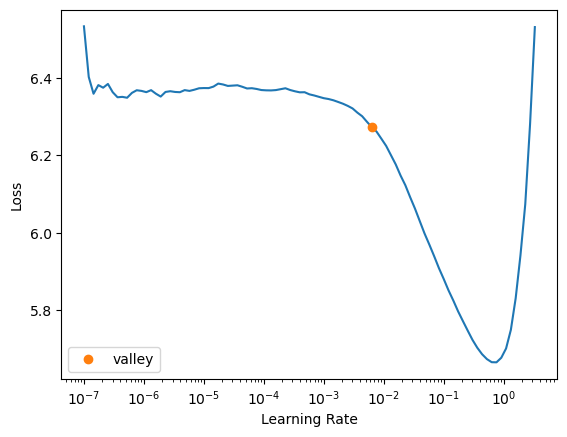

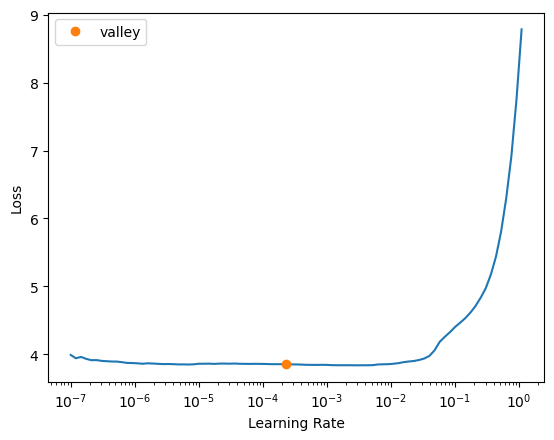

In [13]:
full_lm_clean, full_lang_dls_clean = train_lm(all_clean_data, show_batch=True, epochs=(7,8))

In [14]:
text = 'My flight was delayed'
n_words = 40
n_sentences = 4
test_lm(full_lm_clean, text, n_words, n_sentences)

My flight was delayed so far . @ i can DM you back after an hour . i feel like i have n't received anything about this @ Considering this was not a weather issue , the ground crew was
My flight was delayed for 45 minutes and had an email request . They 're calling and telling them that they needed help @ Cancelled Flightled my flight today , but i now hope that i do . I
My flight was delayed and was leaving shortly after takeoff . # @ Thanks for the help . Just wanted to book a plane . They finally got an update but he could n't get it . @
My flight was delayed until Tuesday , then started to leave at 7 am . Now i miss my connection due to weather . @ My flight is delayed due to mechanical issues . Will you learn your fault


In [15]:
#Save fine-tuned model for future use
acc = 'temp2'
full_lm_clean.save_encoder(f'{model_path}ULMFiT_fine_tuned_LM_full_clean_{acc}')

### Negative Sentiment LM

In [16]:
neg_train = all_clean_data[all_clean_data['negativereason'].notna()].reset_index(drop=True)
neg_train.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

,text,text_
0,"xxbos @ @ @ @ xxup this xxup is xxup everything … now , return that jet so we can go to xxmaj miami ! xxbos @ i am completely xxunk with the service i received on yesterday flying from xxup lga to xxup atl . xxbos @ i believe . xxmaj it was xxmaj cancelled xxmaj flighted yesterday i guess . xxmaj goes back to no notification from xxmaj united about","@ @ @ @ xxup this xxup is xxup everything … now , return that jet so we can go to xxmaj miami ! xxbos @ i am completely xxunk with the service i received on yesterday flying from xxup lga to xxup atl . xxbos @ i believe . xxmaj it was xxmaj cancelled xxmaj flighted yesterday i guess . xxmaj goes back to no notification from xxmaj united about xxmaj"
1,"on xxmaj flight 719 for an hour due to xxmaj sabre being down . xxmaj what backup plan is in place if xxmaj sabre can not be fixed ? xxbos @ to top it all off , your flight attendants talked xxunk xxunk the flight , even when the lights were xxunk . xxmaj resulting in no sleep xxbos @ i think 2 weeks of waiting is more than enough time for","xxmaj flight 719 for an hour due to xxmaj sabre being down . xxmaj what backup plan is in place if xxmaj sabre can not be fixed ? xxbos @ to top it all off , your flight attendants talked xxunk xxunk the flight , even when the lights were xxunk . xxmaj resulting in no sleep xxbos @ i think 2 weeks of waiting is more than enough time for you"
2,xxup nothing ! xxup no xxup options ! trying to get to sick child ! # ! xxbos @ i am very glad i took care of own rescheduling now that xxup ua xxunk from xxup ogg was xxmaj cancelled xxmaj flightled . xxbos @ our flight xxup aa xxunk is delayed out of xxmaj xxunk and will be missing our connection xxup aa xxunk in xxmaj miami to xxup sea .,nothing ! xxup no xxup options ! trying to get to sick child ! # ! xxbos @ i am very glad i took care of own rescheduling now that xxup ua xxunk from xxup ogg was xxmaj cancelled xxmaj flightled . xxbos @ our flight xxup aa xxunk is delayed out of xxmaj xxunk and will be missing our connection xxup aa xxunk in xxmaj miami to xxup sea . xxmaj
3,"get much help … xxmaj as a travel agent this is so disappointing to me . xxbos @ @ but you are xxmaj late xxmaj flight again ! ! xxmaj again and again ! xxmaj where are the crew ? xxbos @ do n't just xxunk on to the safety card . xxmaj it safety was really an issue , then flight would have landed immediately . . xxbos @ i did","much help … xxmaj as a travel agent this is so disappointing to me . xxbos @ @ but you are xxmaj late xxmaj flight again ! ! xxmaj again and again ! xxmaj where are the crew ? xxbos @ do n't just xxunk on to the safety card . xxmaj it safety was really an issue , then flight would have landed immediately . . xxbos @ i did ."


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.881646,4.988138,0.174755,146.663040,00:12
1,5.011844,4.104108,0.251401,60.588696,00:12
2,4.506551,3.966054,0.266789,52.775890,00:12
3,4.242429,3.908258,0.272057,49.812099,00:12
4,4.084508,3.881832,0.274779,48.513016,00:12
5,3.984781,3.869649,0.275529,47.925549,00:12
6,3.942010,3.867916,0.275982,47.842583,00:12


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.881608,3.845329,0.278784,46.774052,00:13
1,3.833328,3.791620,0.286912,44.328144,00:13
2,3.783680,3.759322,0.291529,42.919323,00:13
3,3.731846,3.734128,0.297408,41.851513,00:13
4,3.685768,3.720767,0.298256,41.296036,00:13
5,3.655577,3.717336,0.299203,41.154598,00:13
6,3.644019,3.716727,0.299420,41.129539,00:13
7,3.626866,3.715866,0.299676,41.094162,00:13


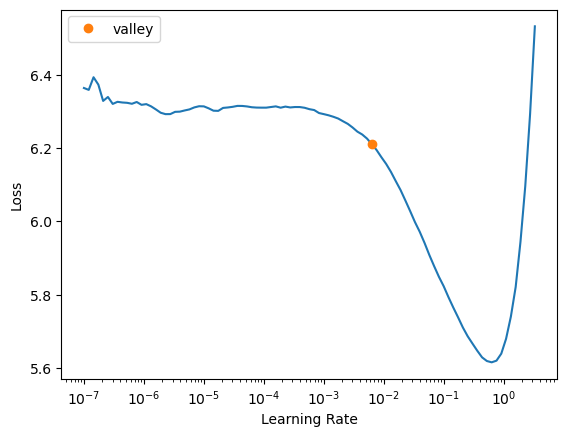

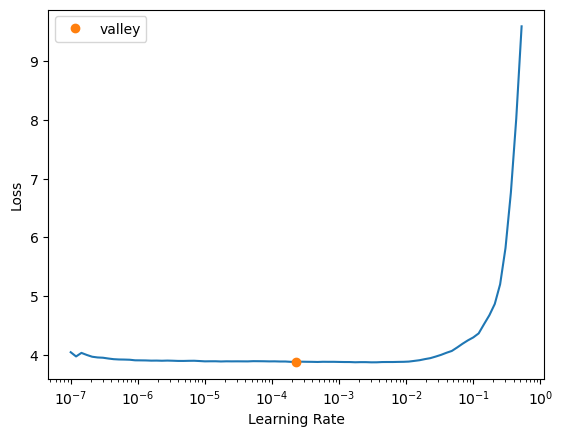

In [17]:
full_lm_neg, lang_dls_neg = train_lm(neg_train, show_batch=True, epochs=(7,8))

In [18]:
text = 'My flight was delayed'
n_words = 40
n_sentences = 4
test_lm(full_lm_neg, text, n_words, n_sentences)

My flight was delayed only to be delayed and Cancelled Flightled . It 's been delayed until the end of the trip . @ We 've been on hold for almost an hr . i 've been on hold
My flight was delayed , but he took my flight to Miami and he had to go back via AA , two days . Thanks for a credit card that he had nothing happening . @ i have no idea
My flight was delayed over an hour , after having to wait for two hours to be put on hold , but those times hold me time and wait to call back . @ so you guys are n't helping me to get
My flight was delayed due to weather and was not working to get to airport . This is ok . Can you help me get a hotel connection ? @ i am at the gate for my SWA flight ,


In [19]:
#Save fine-tuned model for future use
acc = 'temp2'
full_lm_neg.save_encoder(f'{model_path}ULMFiT_fine_tuned_LM_neg_{acc}')

# Intents Full LM

## Sub Groups

In [20]:
intentSubGroups = {
    'Customer Service Issue': 'Customer Service Issue',
    'Late Flight': 'Late Flight',
    'Cancelled Flight': 'Cancelled Flight',
    'Lost Luggage': 'Luggage',
    'Bad Flight': 'Bad Flight',
    'Flight Booking Problems': 'Flight Booking Problems',
    'Flight Attendant Complaints': 'Flight Attendant Complaints',
    'longlines': 'Customer Service Issue',
    'Damaged Luggage': 'Luggage',
    'Can\'t Tell': 'Can\'t Tell'
}

neg_train['intentGroup'] = neg_train.negativereason.apply(lambda x: intentSubGroups[x])

### Train Classifier

,text,category
0,xxbos @ xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag xxrep 3 ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,Luggage
1,xxbos @ xxup xxunk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup xxunk xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup xxunk u xxup and,Bad Flight
2,"xxbos @ i ❤ ️ xxmaj jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr xxmaj late xxmaj flight , div to phx & & got in 2 hrs xxmaj late xxmaj flight . xxmaj what will be done ?",Late Flight
3,xxbos @ @ 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over xxrep 3 !,Flight Booking Problems


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.583682,1.362784,0.548229,3.907056,00:03
1,1.367499,1.266143,0.565123,3.547146,00:03
2,1.278743,1.225219,0.573842,3.404913,00:03
3,1.220272,1.225559,0.570027,3.406068,00:03


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.183428,1.209867,0.578202,3.353040,00:04
1,1.157616,1.206783,0.588011,3.342715,00:04
2,1.159771,1.208105,0.583106,3.347136,00:04
3,1.136807,1.204735,0.590736,3.335876,00:03


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.141963,1.188330,0.592916,3.281596,00:06
1,1.105988,1.196236,0.595095,3.307644,00:05
2,1.065810,1.120607,0.622343,3.066715,00:05
3,0.977043,1.122684,0.622343,3.073093,00:05
4,0.885140,1.104876,0.628883,3.018850,00:05
5,0.803412,1.120744,0.629973,3.067136,00:05
6,0.743205,1.114302,0.627793,3.047440,00:05
7,0.709527,1.114476,0.631063,3.047971,00:05
8,0.677947,1.123289,0.617984,3.074951,00:05


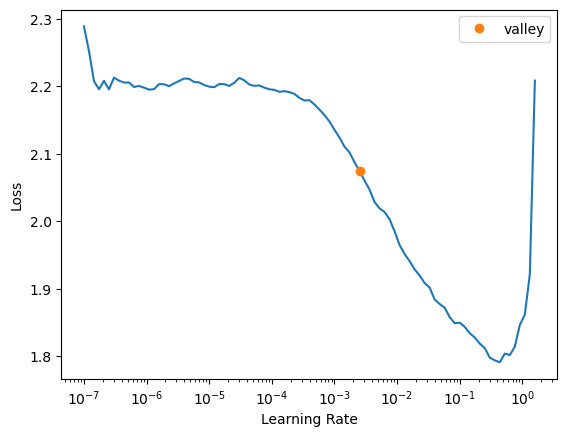

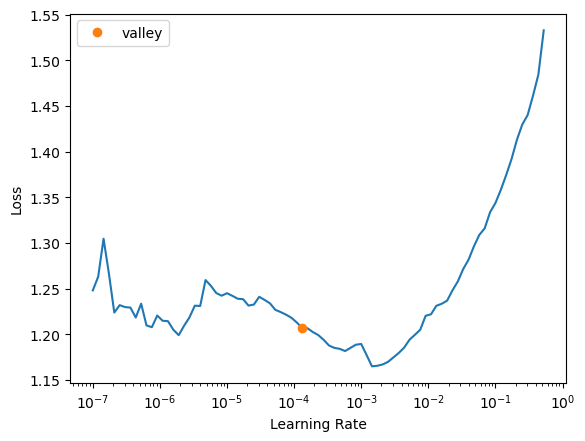

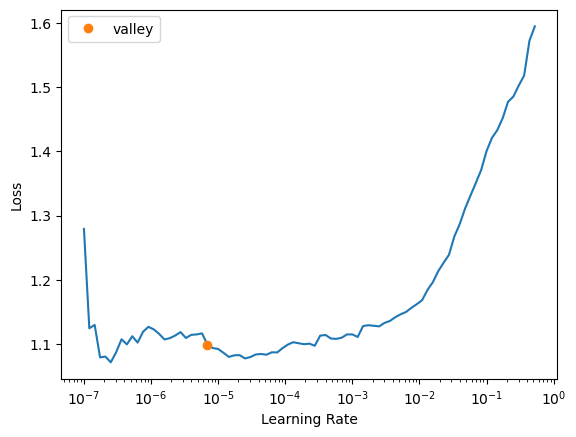

In [21]:
acc = 'temp'
encoder_path = model_path + f'ULMFiT_fine_tuned_LM_full_clean_{acc}'
intent_classifier = train_classifier(neg_train, full_lang_dls_clean, encoder_path, label='intentGroup')

In [22]:
acc = test_classifier_acc(intent_classifier)
print(acc)

TensorBase(0.6180)


In [23]:
acc = test_classifier_acc(intent_classifier)
intent_classifier.save(f'{model_path}ULMFiT_intent_full_class_subgroup_{acc.item()}')

Path('/home/jupyter/src/natalies-little-helper/models/ULMFiT_intent_full_class_subgroup_0.6179836392402649.pth')

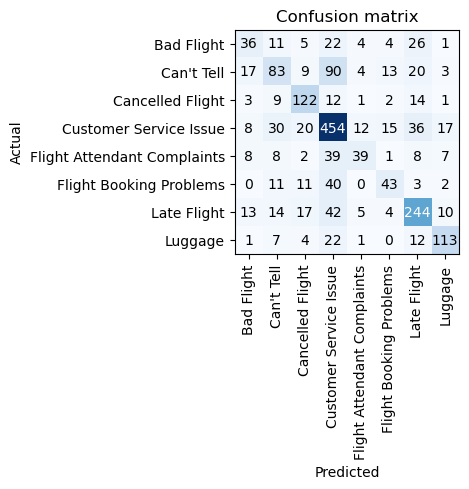

In [24]:
interp = ClassificationInterpretation.from_learner(intent_classifier)
interp.plot_confusion_matrix()

In [25]:
text = '@VirginAmerica How do I reschedule my Cancelled Flightled flights online? The change button is greyed out!'
intent_classifier.predict(text)

('Cancelled Flight',
 tensor(2),
 tensor([2.0213e-03, 1.9997e-03, 6.9477e-01, 1.5624e-01, 6.1646e-04, 1.4337e-01,
         5.9053e-04, 3.8577e-04]))

In [26]:
# all_clean_data['intent_pred'] = all_clean_data['text'].apply(lambda x: intent_classifier.predict(x))

### Train Sampled Classifier

In [27]:
neg_train_sampled = neg_train.groupby('intentGroup').apply(lambda x: x.sample(min(750, len(x)))).reset_index(drop=True)

,text,category
0,xxbos @ xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag xxrep 3 ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,Luggage
1,xxbos @ @ 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over xxrep 3 !,Flight Booking Problems
2,xxbos @ - xxup seriously it 's 2015 ? ! ? ! xxup no wifi on a 5hr flight from xxup cle - sfo # . xxmaj you 're the xxup only airline w / out wifi … and pls no ' xxunk ' xxup bs .,Bad Flight
3,xxbos @ xxup fail xxmaj you xxmaj cancelled xxmaj flightled our flight frm xxup xxunk and then used our reserv home to xxup iah ( from xxup sea ) for reflight xxmaj booking xxmaj problems w / out xxup our xxup xxunk ! ! #,Cancelled Flight


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.692666,1.415784,0.517790,4.119713,00:02
1,1.505161,1.355581,0.537453,3.879015,00:02
2,1.382413,1.321448,0.551498,3.748846,00:02
3,1.318113,1.302143,0.559925,3.677170,00:02


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.263569,1.300693,0.566479,3.671839,00:02
1,1.260848,1.308189,0.554307,3.699467,00:02
2,1.261438,1.302410,0.562734,3.678149,00:02
3,1.255405,1.308770,0.565543,3.701619,00:02


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.257282,1.280655,0.568352,3.598995,00:03
1,1.223754,1.223941,0.604869,3.400564,00:03
2,1.136199,1.207132,0.587079,3.343881,00:03
3,1.039338,1.193601,0.607678,3.298939,00:03
4,0.961642,1.193235,0.598315,3.297731,00:03


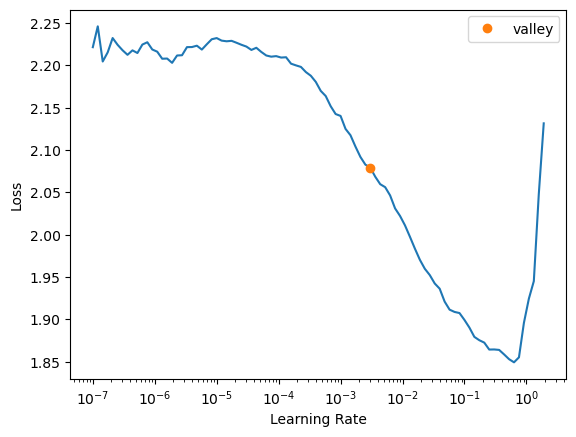

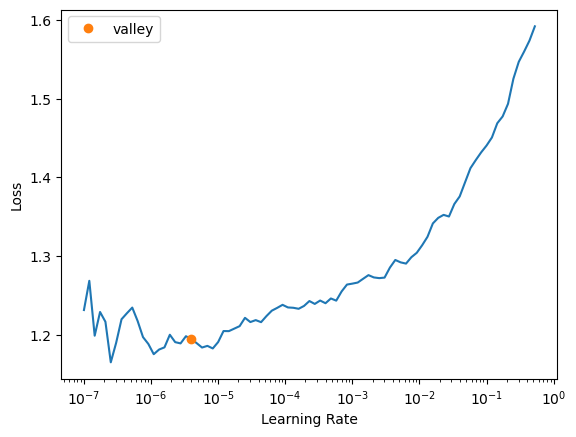

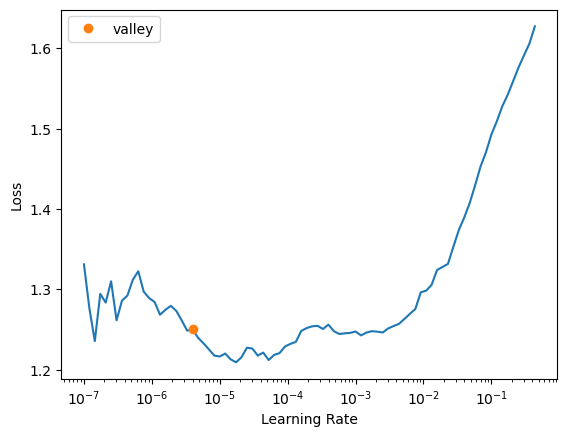

In [28]:
acc = 'temp'
encoder_path = model_path + f'ULMFiT_fine_tuned_LM_full_clean_{acc}'
epochs = (4, 4, 5)
intent_sampled_classifier = train_classifier(neg_train_sampled, full_lang_dls_clean, encoder_path, label='intentGroup', epochs=epochs)

In [29]:
acc = test_classifier_acc(intent_sampled_classifier)
print(acc)

TensorBase(0.5983)


In [30]:
acc = test_classifier_acc(intent_sampled_classifier)
intent_sampled_classifier.save(f'{model_path}ULMFiT_intent_full_class_subgroup_sample_{acc.item()}')

Path('/home/jupyter/src/natalies-little-helper/models/ULMFiT_intent_full_class_subgroup_sample_0.5983145833015442.pth')

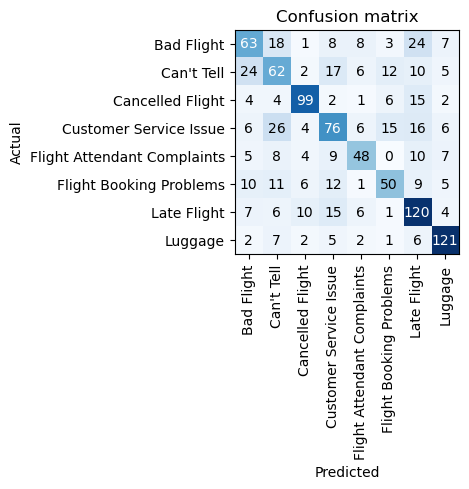

In [31]:
interp = ClassificationInterpretation.from_learner(intent_sampled_classifier)
interp.plot_confusion_matrix()

In [32]:
text = '@VirginAmerica How do I reschedule my Cancelled Flightled flights online? The change button is greyed out!'
intent_sampled_classifier.predict(text)

('Cancelled Flight',
 tensor(2),
 tensor([1.7562e-03, 3.4317e-03, 7.4904e-01, 4.3599e-02, 2.1142e-03, 1.9693e-01,
         2.4814e-03, 6.4921e-04]))

In [33]:
# all_clean_data['intent_sampled_pred'] = all_clean_data['text'].apply(lambda x: intent_sampled_classifier.predict(x))

## Master Groups

In [34]:
intentMasterGroups = {
    'Customer Service Issue': 'Customer Service',
    'Late Flight': 'Flights',
    'Cancelled Flight': 'Flights',
    'Lost Luggage': 'Luggage',
    'Bad Flight': 'Flights',
    'Flight Booking Problems': 'Customer Service',
    'Flight Attendant Complaints': 'Customer Service',
    'longlines': 'Customer Service',
    'Damaged Luggage': 'Luggage',
    'Can\'t Tell': 'Can\'t Tell'
}

neg_train['intentMasterGroups'] = neg_train.negativereason.apply(lambda x: intentMasterGroups[x])

### Train Classifier

,text,category
0,xxbos @ xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag xxrep 3 ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,Luggage
1,xxbos @ xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup xxunk xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! #,Customer Service
2,xxbos @ xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup xxunk just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help ?,Customer Service
3,xxbos @ no delay . i pay $ xxrep 3 7 xxunk for xxup bs xxup a1 ticket . xxmaj you boarded flight early . xxmaj i 'm last to board . xxmaj now have middle seat . xxmaj wasted xxrep 4 $ !,Flights


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.061776,0.905205,0.670300,2.472438,00:03
1,0.924718,0.808109,0.672480,2.243662,00:03
2,0.835862,0.792041,0.689373,2.207898,00:03
3,0.792761,0.784356,0.687193,2.190996,00:03


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.777749,0.783344,0.685014,2.188779,00:04
1,0.786504,0.783003,0.681744,2.188032,00:04
2,0.743248,0.776780,0.684469,2.174459,00:04
3,0.755200,0.780846,0.684469,2.183317,00:04


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.753766,0.766792,0.693188,2.152848,00:05
1,0.758270,0.742819,0.698093,2.101853,00:05
2,0.708299,0.757153,0.704087,2.132196,00:06
3,0.639579,0.742898,0.705177,2.102017,00:05
4,0.575105,0.746902,0.711172,2.110452,00:05
5,0.521757,0.750225,0.713351,2.117476,00:05
6,0.463300,0.772059,0.710082,2.164218,00:05
7,0.440170,0.773743,0.711172,2.167866,00:05
8,0.428447,0.784693,0.710082,2.191733,00:05


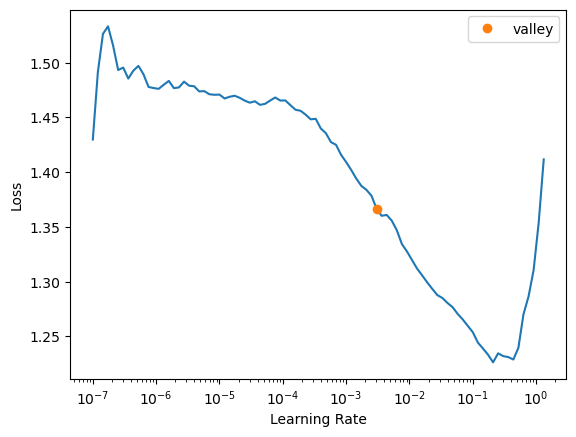

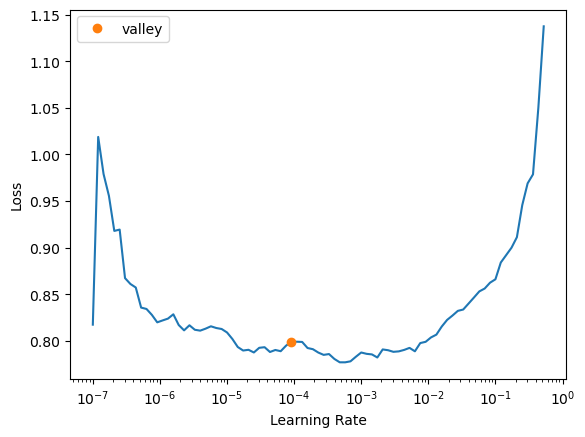

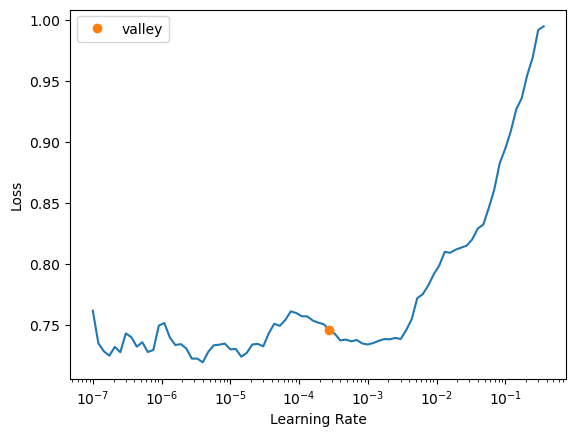

In [35]:
acc = 'temp'
encoder_path = model_path + f'ULMFiT_fine_tuned_LM_full_clean_{acc}'
intent_master_classifier = train_classifier(neg_train, full_lang_dls_clean, encoder_path, label='intentMasterGroups')

In [36]:
acc = test_classifier_acc(intent_master_classifier)
print(acc)

TensorBase(0.7101)


In [37]:
acc = test_classifier_acc(intent_master_classifier)
intent_master_classifier.save(f'{model_path}ULMFiT_intent_full_class_mastergroup_{acc.item()}')

Path('/home/jupyter/src/natalies-little-helper/models/ULMFiT_intent_full_class_mastergroup_0.7100817561149597.pth')

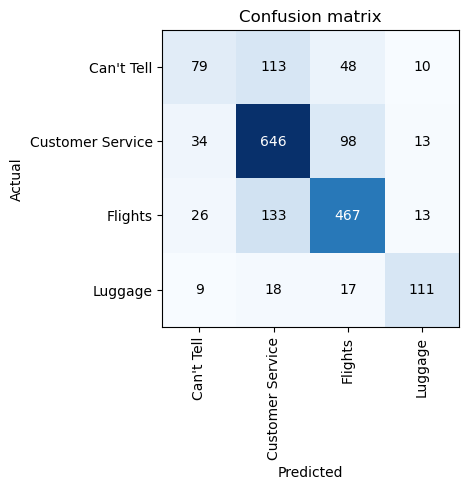

In [38]:
interp = ClassificationInterpretation.from_learner(intent_master_classifier)
interp.plot_confusion_matrix()

In [39]:
text = '@VirginAmerica How do I reschedule my Cancelled Flightled flights online? The change button is greyed out!'
intent_master_classifier.predict(text)

('Customer Service',
 tensor(1),
 tensor([5.5851e-04, 9.1586e-01, 8.3459e-02, 1.2609e-04]))

In [40]:
# all_clean_data['intent_mastergroup_pred'] = all_clean_data['text'].apply(lambda x: intent_master_classifier.predict(x))

### Train Sampled Classifier

In [41]:
neg_train_master_sampled = neg_train.groupby('intentMasterGroups').apply(lambda x: x.sample(min(1000, len(x)))).reset_index(drop=True)

,text,category
0,xxbos @ xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag xxrep 3 ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,Luggage
1,"xxbos @ our ft xxunk xxup xxunk / xxup dfw ( w / cx to xxup lga ) tomorrow xxmaj cancelled xxmaj flighted , 4 hrs so far waiting for call back . xxmaj what should we do ? xxmaj need to get to nyc",Customer Service
2,xxbos @ xxup fail xxmaj you xxmaj cancelled xxmaj flightled our flight frm xxup xxunk and then used our reserv home to xxup iah ( from xxup sea ) for reflight xxmaj booking xxmaj problems w / out xxup our xxup xxunk ! ! #,Flights
3,"xxbos @ xxmaj waiting for xxunk xxup ewr - ord , delayed 47 mins . xxmaj might miss xxunk xxup ord - xxunk at 6 pm xxup ct . xxmaj any room on xxunk xxup ord - xxunk in case i miss xxunk ?",Flights


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.206838,0.983858,0.632411,2.674754,00:02
1,1.074745,0.963191,0.604743,2.620045,00:02
2,0.980767,0.947141,0.617918,2.578327,00:02
3,0.929199,0.943537,0.624506,2.569051,00:02


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.894130,0.938749,0.619236,2.556780,00:02
1,0.876431,0.937371,0.625823,2.553260,00:02
2,0.873850,0.948962,0.629776,2.583027,00:02
3,0.874303,0.934566,0.624506,2.546108,00:02


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.882541,0.931886,0.631094,2.539293,00:02
1,0.861451,0.901134,0.649539,2.462395,00:02
2,0.792567,0.863465,0.653491,2.371364,00:02
3,0.712717,0.876404,0.652174,2.402246,00:03
4,0.644643,0.884830,0.654809,2.422572,00:02


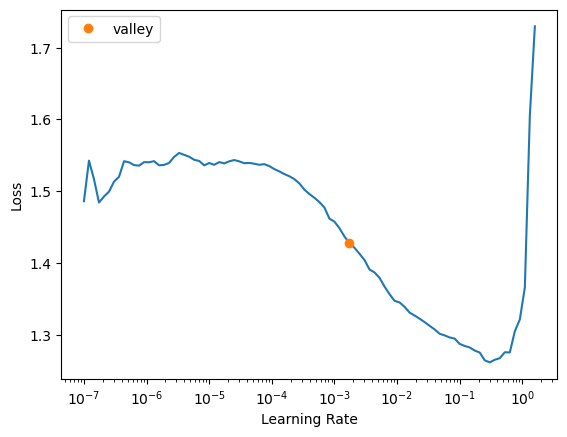

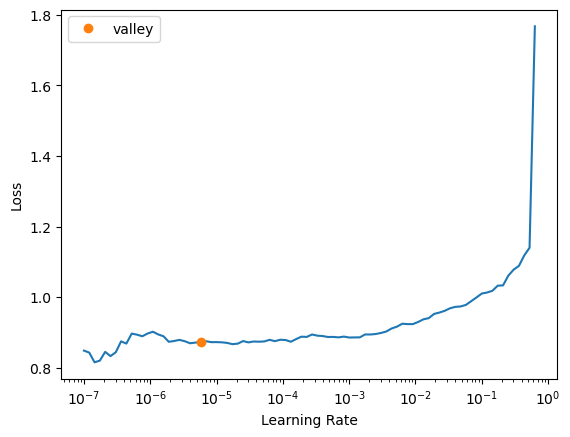

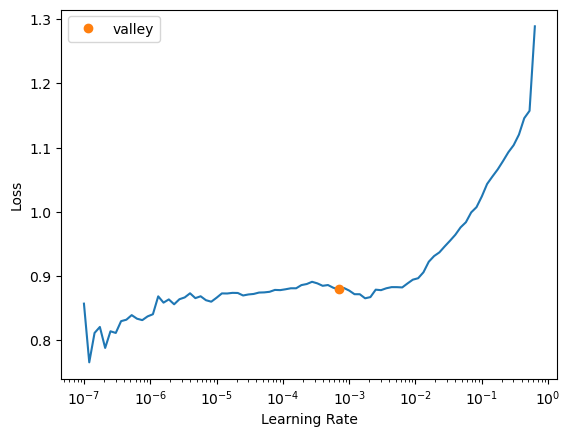

In [42]:
acc = 'temp'
encoder_path = model_path + f'ULMFiT_fine_tuned_LM_full_clean_{acc}'
epochs = (4, 4, 5)
intent_master_sampled_classifier = train_classifier(neg_train_master_sampled, full_lang_dls_clean, encoder_path, label='intentMasterGroups', epochs=epochs)

In [43]:
acc = test_classifier_acc(intent_master_sampled_classifier)
print(acc)

TensorBase(0.6548)


In [44]:
acc = test_classifier_acc(intent_master_sampled_classifier)
intent_master_sampled_classifier.save(f'{model_path}ULMFiT_intent_full_class_matergroup_sample_{acc.item()}')

Path('/home/jupyter/src/natalies-little-helper/models/ULMFiT_intent_full_class_matergroup_sample_0.6548089385032654.pth')

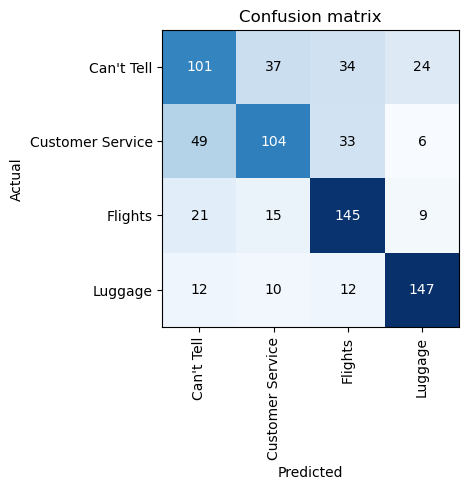

In [45]:
interp = ClassificationInterpretation.from_learner(intent_master_sampled_classifier)
interp.plot_confusion_matrix()

In [46]:
text = '@VirginAmerica How do I reschedule my Cancelled Flightled flights online? The change button is greyed out!'
intent_master_sampled_classifier.predict(text)

('Flights', tensor(2), tensor([0.0147, 0.4235, 0.5583, 0.0036]))

In [47]:
# all_clean_data['intent_sampled_pred'] = all_clean_data['text'].apply(lambda x: intent_sampled_classifier.predict(x))

## Store Models

In [49]:
print(os.getcwd())

/home/jupyter/src/natalies-little-helper/notebooks


In [55]:
intent_classifier.path = (Path(os.getcwd())).parent.absolute() / 'models' / 'ULMFiT' / 'final'
intent_classifier.export('intent_classifier.pkl')

In [58]:
intent_sampled_classifier.path = (Path(os.getcwd())).parent.absolute() / 'models' / 'ULMFiT' / 'final'
intent_sampled_classifier.export('intent_sampled_classifier.pkl')

In [74]:
intent_master_classifier.path = (Path(os.getcwd())).parent.absolute() / 'models' / 'ULMFiT' / 'final'
intent_master_classifier.export('intent_master_classifier.pkl')

In [73]:
intent_master_sampled_classifier.path = (Path(os.getcwd())).parent.absolute() / 'models' / 'ULMFiT' / 'final'
intent_master_sampled_classifier.export('intent_master_sampled_classifier.pkl')

## Access Models

In [56]:
path = (Path(os.getcwd())).parent.absolute() / 'models' / 'ULMFiT' / 'final'
model_name = 'intent_classifier.pkl'
learn = load_learner(path / model_name)

In [57]:
learn.predict(text)

('Cancelled Flight',
 tensor(2),
 tensor([2.0185e-03, 1.9993e-03, 6.9527e-01, 1.5599e-01, 6.1615e-04, 1.4314e-01,
         5.8964e-04, 3.8497e-04]))

In [71]:
learner = helper.load_ulmfit_classifier('intent_groups')
learner.predict(text)

('Cancelled Flight',
 tensor(2),
 tensor([2.0185e-03, 1.9993e-03, 6.9527e-01, 1.5599e-01, 6.1615e-04, 1.4314e-01,
         5.8964e-04, 3.8497e-04]))